In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

In [2]:
object_points_list = []  # 3d points in real world space. (Same for all)
image_points_list = []  # 2d points in image plane.

In [3]:
nx, ny = 9, 6  # inside corners in rows, columns
object_points = np.zeros((nx * ny, 3), np.float32)
object_points[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

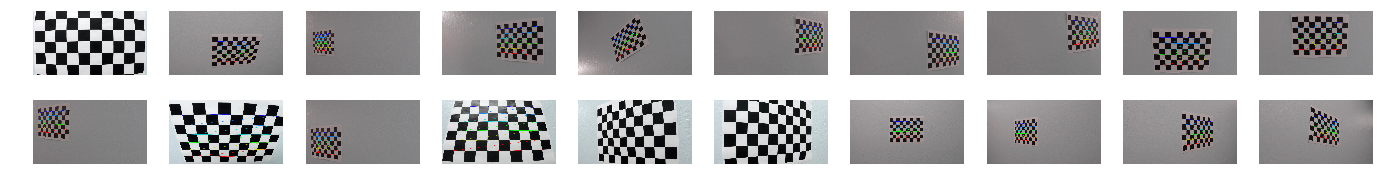

In [4]:
images = glob.glob("camera_cal/calibration*.jpg")
assert len(images) == 20
plt.figure(figsize=(24, 3))
for i in range(len(images)):
    img = cv2.imread(images[i])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    retval, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if retval:
        cv2.drawChessboardCorners(img, (nx, ny), corners, retval)
        image_points_list.append(corners)
        object_points_list.append(object_points)
    plt.subplot(2, 10, i + 1)
    plt.axis('off')
    plt.imshow(img)

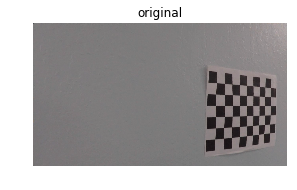

In [5]:
plt.figure(figsize=(10, 10))
img = cv2.imread(images[6])
plt.subplot(1, 2, 1)
plt.title('original')
plt.axis('off')
plt.imshow(img)

In [6]:
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points_list, image_points_list, img_size, None, None)
img = cv2.undistort(img, mtx, dist, None, mtx)

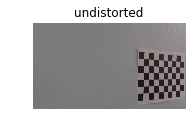

In [7]:
plt.subplot(1, 2, 2)
plt.title('undistorted')
plt.axis('off')
plt.imshow(img);

In [8]:
print('"Just to know what they look like,"\n')
print('cameraMatrix= ', mtx, '\n')
print('distCoeffs= ', dist)

"Just to know what they look like,"

cameraMatrix=  [[  1.15396093e+03   0.00000000e+00   6.69705377e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656222e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]] 

distCoeffs=  [[ -2.41017955e-01  -5.30721337e-02  -1.15810320e-03  -1.28318084e-04
    2.67125925e-02]]


In [9]:
dumpling = {'mtx': mtx, 'dist': dist}
pickle.dump(dumpling, open("camera_calibration_param.p", "wb"))

In [10]:
with open("camera_calibration_param.p", mode='rb') as f:
    calibration_param = pickle.load(f)
bla1, bla2 = calibration_param["mtx"], calibration_param["dist"]
print('Testing pickles:')
print('mtx= ', bla1, '\n')
print('dist= ', bla2)

Testing pickles:
mtx=  [[  1.15396093e+03   0.00000000e+00   6.69705377e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656222e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]] 

dist=  [[ -2.41017955e-01  -5.30721337e-02  -1.15810320e-03  -1.28318084e-04
    2.67125925e-02]]


In [11]:
from collections import deque
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import numpy as np
import pickle
%matplotlib inline

In [12]:
def plot_2(images, titles):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))    
    ax1.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
    ax1.set_title(titles[0])    
    ax2.imshow(cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB))
    ax2.set_title(titles[1])

In [13]:
with open("camera_calibration_param.p", mode='rb') as f:
    calibration_param = pickle.load(f)
cameraMatrix, distCoeffs = calibration_param["mtx"], calibration_param["dist"]

In [14]:
def undistort(image, show=True, read = True):
    if read:
        img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])
    undist = cv2.undistort(img, cameraMatrix, distCoeffs, None, cameraMatrix)
    if show:
        plot_2((img, undist), ('Original Image', 'Undistorted Image'))
    else:
        return undist

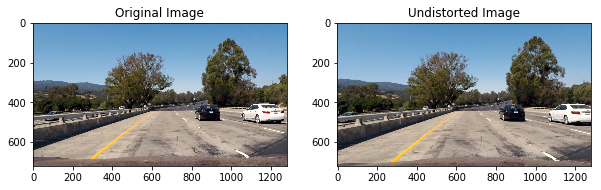

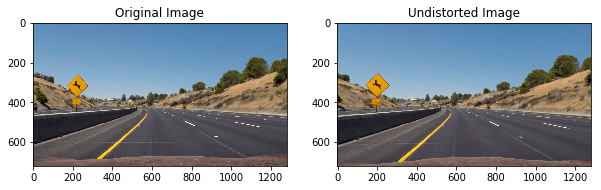

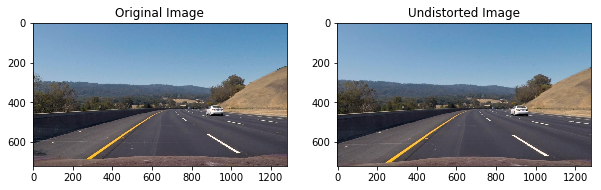

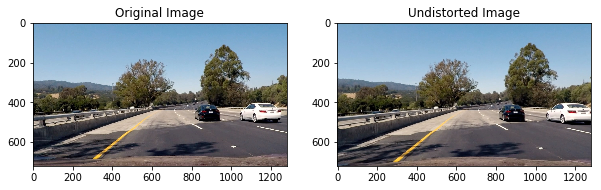

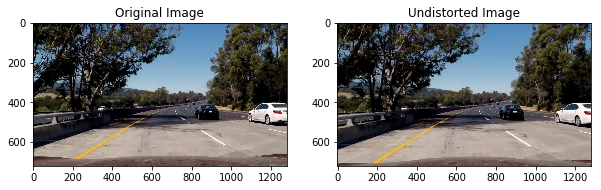

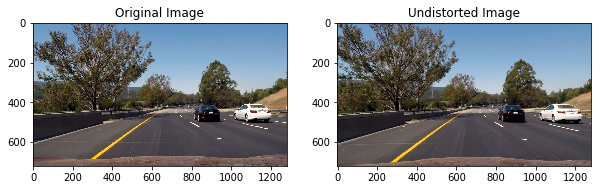

In [15]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    undistort(image)

In [16]:
def perspective_transform(img, display=True, read = True):
    if read:
        undist = undistort(img, show = False)
    else:
        undist = undistort(img, show = False, read=False) 
    img_size = (undist.shape[1], undist.shape[0])
    
    src = np.float32([[492, 485],[805, 485],
                      [1245, 720],[42, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    if display:
        plot_2((undist, warped), ('Undistorted', 'Warped'))
    else:
        return warped, M

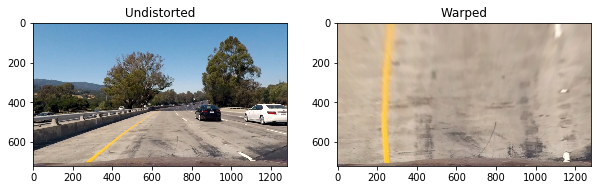

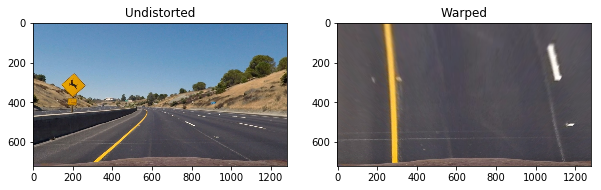

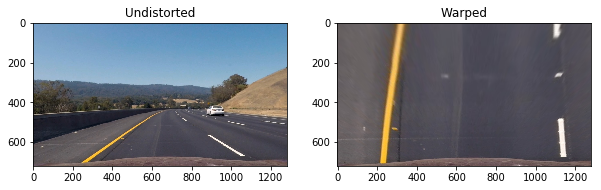

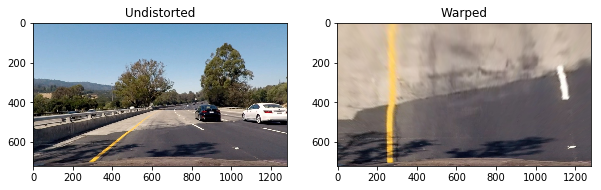

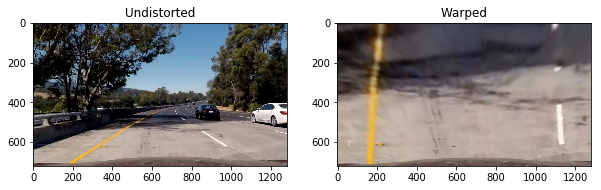

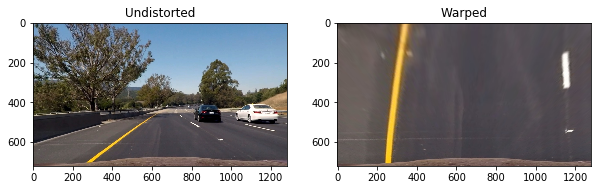

In [17]:
for image in glob.glob('test_images/test*.jpg'):
    perspective_transform(image)

In [18]:
def combined_binary(image, show=True):
    img, M = perspective_transform(image, display = False)

    s_chan = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    l_chan = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    b_chan = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    s_min = 181
    s_max = 255
    s_bin = np.zeros_like(s_chan)
    s_bin[(s_chan >= s_min) & 
             (s_chan <= s_max)] = 1
    
    b_min = 153
    b_max = 202
    b_bin = np.zeros_like(b_chan)
    b_bin[(b_chan >= b_min) & 
             (b_chan <= b_max)] = 1
    
    l_min = 220
    l_max = 255
    l_bin = np.zeros_like(l_chan)
    l_bin[(l_chan >= l_min) & 
             (l_chan <= l_max)] = 1

    combined_bin = np.zeros_like(s_bin)
    combined_bin[(l_bin == 1) | (b_bin == 1)] = 1

    if show == True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))    
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Warped')    
        ax2.imshow(combined_bin, cmap='gray')
        ax2.set_title('Combined Binary')
    else: 
        return combined_bin

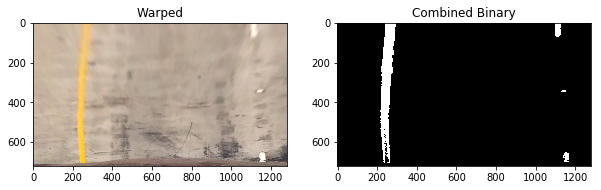

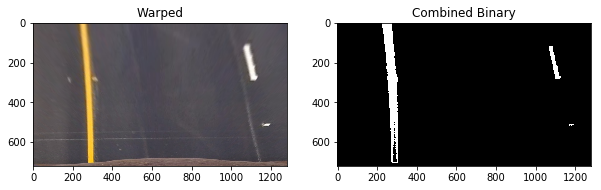

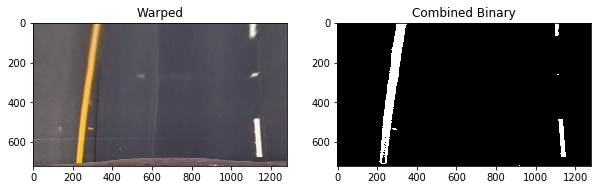

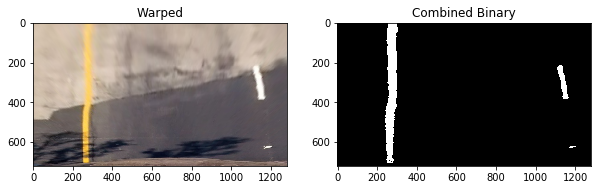

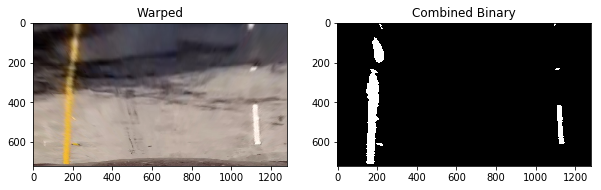

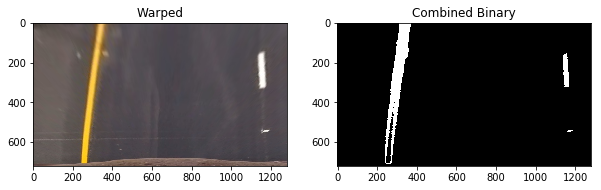

In [19]:
for image in glob.glob('test_images/test*.jpg'):
    combined_binary(image)

In [20]:
def fit_polynomial(image):
    combined_bin = combined_binary(image, show=False)
    
    rightx = []
    righty = []
    leftx = []
    lefty = []
    
    x, y = np.nonzero(np.transpose(combined_bin))
    i = 720
    j = 630
    while j >= 0:
        histogram = np.sum(combined_bin[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    
    righty = righty[rsort]
    rightx = rightx[rsort]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    # Radius calculation
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/200 # meteres per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty)/2 + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty)/2 + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    # Offset from center
    center = abs(640 - ((rightx_int+leftx_int)/2))
    offset = 0
    img_size = (combined_bin.shape[1], combined_bin.shape[0])
    
    src = np.float32([[492, 485],[805, 485],
                      [1245, 720],[42, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_bin).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    warp_again = cv2.warpPerspective(color_warp, Minv, (combined_bin.shape[1], combined_bin.shape[0]))
    finale = cv2.addWeighted(mpimg.imread(image), 1, warp_again, 0.5, 0)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 6))
    f.tight_layout()
    
    ax1.imshow(cv2.cvtColor((perspective_transform(image, display=False)[0]), cv2.COLOR_BGR2RGB))
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(0, 720)
    
    ax1.plot(left_fitx, lefty, color='red', linewidth=3)
    ax1.plot(right_fitx, righty, color='blue', linewidth=3)
    
    ax1.set_title('Lane Lines', fontsize=16)
    ax1.invert_yaxis() # to visualize as we do the images
    
    ax2.imshow(finale)
    ax2.set_title('Lane Painted', fontsize=16)
    
    if center < 640:
        ax2.text(200, 100, 'Vehicle is on {:.2f} m left of center'.
                 format(center*3.7/700),
                 color='white', fontsize=11)
    else:
        ax2.text(200, 100, 'Vehicle is on {:.2f} m right of center'.
                 format(center*3.7/700),
                 color='white', fontsize=11)
    ax2.text(200, 175, 'Curvature radius = {} m'.
             format(int((left_curverad + right_curverad)/2)),
             color='white', fontsize=11)

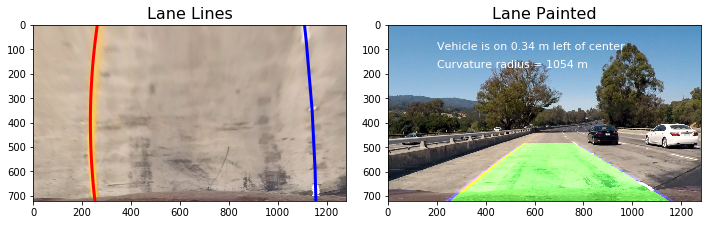

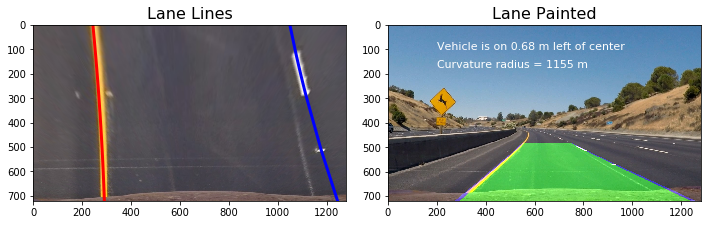

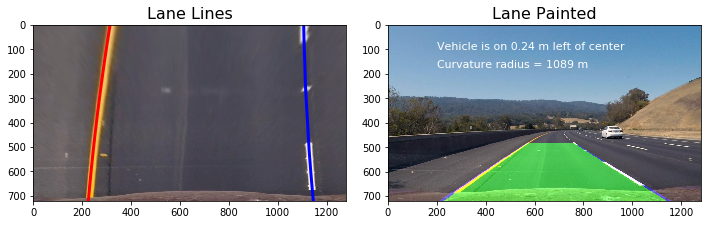

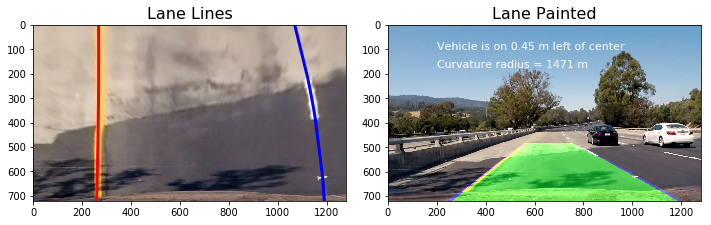

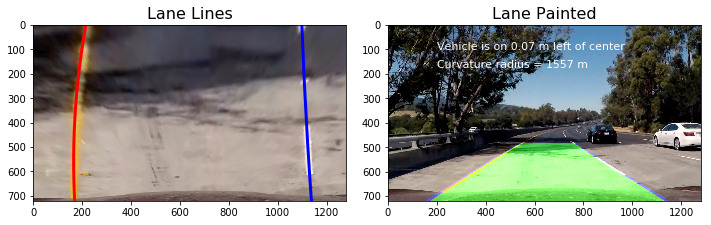

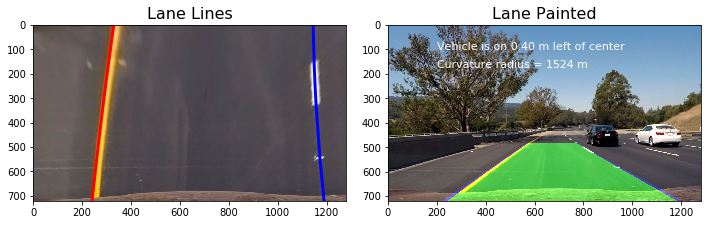

In [21]:
for image in glob.glob('test_images/test*.jpg'):
    fit_polynomial(image)

In [22]:
class Line:
    def __init__(self):
        self.found = False

        # X and y values of lanes in prev frame
        self.X = None
        self.Y = None

        # Recent interceptions
        self.interceptions = deque(maxlen=10)
        self.interceptions_top = deque(maxlen=10)

        # Last interception
        self.last_interception = None
        self.last_intersection_top = None

        self.radius = None

        # Recent polynomial coefficients
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.points = []

        self.frame_number = 0

    def found_search(self, x, y):
        # Do sliding window search around previously found polynomial line
        xvals = []
        yvals = []
        if self.found == True:
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i, j])
                xval = (np.mean(self.fit0)) * yval ** 2 + (np.mean(self.fit1)) * yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x) & (x < (xval + 25)) & ((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0:
            self.found = False  # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found

    def blind_search(self, x, y, image):
        # Find polynomial lines from scratch
        xvals = []
        yvals = []
        if self.found == False:
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i, :], axis=0)
                if self == Right_Lane:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x) & (x < (peak + 25)) & ((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found

    def curvature_calc(self, xvals, yvals):
        y_eval = np.max(yvals)/2
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/200 # meters per pixel in x dimension
        
        
        very_fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)

        rad = ((1 + (2*very_fit_cr[0]*y_eval + very_fit_cr[1])**2)**1.5) / np.absolute(2*very_fit_cr[0])

        #print('Rad = ', rad)
        return rad

    def sort_values(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals

    def get_interceptions(self, polynomial):
        bottom = polynomial[0] * 720 ** 2 + polynomial[1] * 720 + polynomial[2]
        top = polynomial[0] * 0 ** 2 + polynomial[1] * 0 + polynomial[2]
        return bottom, top

In [23]:
Left_Lane = Line()
Right_Lane = Line()

In [24]:
src = np.float32([[492, 485], [805, 485],
                  [1245, 720], [42, 720]])
dst = np.float32([[0, 0], [1280, 0],
                  [1250, 720], [40, 720]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

In [25]:
def process_frame(image):
    img_size = (image.shape[1], image.shape[0])

    undist = cv2.undistort(image, cameraMatrix, distCoeffs, None, cameraMatrix)
    warped = cv2.warpPerspective(undist, M, img_size)

    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:, :, 2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:, :, 0]

    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_bin = np.zeros_like(b_binary)
    combined_bin[(l_binary == 1) | (b_binary == 1)] = 1

    x, y = np.nonzero(np.transpose(combined_bin))

    if Left_Lane.found == True:
        leftx, lefty, Left_Lane.found = Left_Lane.found_search(x, y)

    if Right_Lane.found == True:
        rightx, righty, Right_Lane.found = Right_Lane.found_search(x, y)

    if Right_Lane.found == False:
        rightx, righty, Right_Lane.found = Right_Lane.blind_search(x, y, combined_bin)

    if Left_Lane.found == False:
        leftx, lefty, Left_Lane.found = Left_Lane.blind_search(x, y, combined_bin)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)

    # -----------------------

    left_fit = np.polyfit(lefty, leftx, 2)

    new_left_interception, new_left_interception_top = Left_Lane.get_interceptions(left_fit)

    # Average interceptions through frames
    Left_Lane.interceptions.append(new_left_interception)
    Left_Lane.interceptions_top.append(new_left_interception_top)

    new_left_interception = np.mean(Left_Lane.interceptions)
    new_left_interception_top = np.mean(Left_Lane.interceptions_top)

    Left_Lane.last_interception = new_left_interception
    Left_Lane.last_intersection_top = new_left_interception_top

    # Add averaged interceptions to current x and y
    leftx = np.append(leftx, new_left_interception)
    lefty = np.append(lefty, 720)

    leftx = np.append(leftx, new_left_interception_top)
    lefty = np.append(lefty, 0)

    # Sort detected pixels based on the y's
    leftx, lefty = Left_Lane.sort_values(leftx, lefty)

    Left_Lane.X = leftx
    Left_Lane.Y = lefty

    # Recalculate polynomial with intercepts
    left_fit = np.polyfit(lefty, leftx, 2)

    # Average through frames
    Left_Lane.fit0.append(left_fit[0])
    Left_Lane.fit1.append(left_fit[1])
    Left_Lane.fit2.append(left_fit[2])
    left_fit = [np.mean(Left_Lane.fit0),
                np.mean(Left_Lane.fit1),
                np.mean(Left_Lane.fit2)]

    # Fit polynomial to detected pixels
    left_fitx = left_fit[0] * lefty ** 2 + left_fit[1] * lefty + left_fit[2]
    Left_Lane.fitx = left_fitx

    # -----------------------
    # Now do all same for right lane:

    right_fit = np.polyfit(righty, rightx, 2)

    new_right_interception, new_right_interception_top = Right_Lane.get_interceptions(right_fit)

    # Average interceptions through frames
    Right_Lane.interceptions.append(new_right_interception)
    new_right_interception = np.mean(Right_Lane.interceptions)

    Right_Lane.interceptions_top.append(new_right_interception_top)
    new_right_interception_top = np.mean(Right_Lane.interceptions_top)

    Right_Lane.last_interception = new_right_interception
    Right_Lane.last_intersection_top = new_right_interception_top

    # Add averaged interceptions to current x and y

    rightx = np.append(rightx, new_right_interception)
    righty = np.append(righty, 720)

    rightx = np.append(rightx, new_right_interception_top)
    righty = np.append(righty, 0)

    # Sort detected pixels based on the y's
    rightx, righty = Right_Lane.sort_values(rightx, righty)

    Right_Lane.X = rightx
    Right_Lane.Y = righty

    # Recalculate polynomial with intercepts
    right_fit = np.polyfit(righty, rightx, 2)

    # Average through frames
    Right_Lane.fit0.append(right_fit[0])
    Right_Lane.fit1.append(right_fit[1])
    Right_Lane.fit2.append(right_fit[2])
    right_fit = [np.mean(Right_Lane.fit0), np.mean(Right_Lane.fit1), np.mean(Right_Lane.fit2)]

    # Fit polynomial to detected pixels
    right_fitx = right_fit[0] * righty ** 2 + right_fit[1] * righty + right_fit[2]
    Right_Lane.fitx = right_fitx

    # -----------------------

    # Compute radius of curvature for each lane in meters
    left_curverad = Left_Lane.curvature_calc(leftx, lefty)
    right_curverad = Right_Lane.curvature_calc(rightx, righty)

    # Print the curvature every 4 frames
    if Left_Lane.frame_number % 4 == 0:
        Left_Lane.radius = left_curverad
        Right_Lane.radius = right_curverad

    # Calculate offset from center
    position = (new_right_interception + new_left_interception) / 2
    distance_from_center = abs((640 - position) * 3.7 / 700)

    warp_zero = np.zeros_like(combined_bin).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left_Lane.fitx, Left_Lane.Y])))])

    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right_Lane.Y]))])

    pts = np.hstack((pts_left, pts_right))

    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0, 0, 255), thickness=40)
    cv2.fillPoly(color_warp, np.int_(pts), (40, 255, 40))

    unwarped_lanes = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    finale = cv2.addWeighted(undist, 1, unwarped_lanes, 0.5, 0)

    if position > 640:
        cv2.putText(finale, 'Vehicle is on {:.2f}m left of center'.format(distance_from_center), (100, 80),
                    fontFace=16, fontScale=2, color=(255, 255, 255), thickness=2)
    else:
        cv2.putText(finale, 'Vehicle is on {:.2f}m right of center'.format(distance_from_center), (100, 80),
                    fontFace=16, fontScale=2, color=(255, 255, 255), thickness=2)

    cv2.putText(finale, 'Radius of Curvature {}(m)'.format(int((Left_Lane.radius + Right_Lane.radius) / 2)), (120, 140),
                fontFace=16, fontScale=2, color=(255, 255, 255), thickness=2)
    Left_Lane.frame_number += 1
    return finale

In [26]:
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [12:52<00:00,  1.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [27]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))